This notebook explores the reduction of the number of amino acids to the number of classes of aminoacids (4 classes). The aim of this reduction would be to avoid overfitting. We regrouped the amino acids that are alike, and then assigned one channel of the CNN to each group.

In [31]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import KFold

import os
from collections import Counter
from helpers import *


1. Load the dataset 

In [32]:
#load training data (will be put in a function later)  
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'train_v1.csv',index_col="seq_id")
train_df = train_df.drop(columns=['data_source'])
train_df = train_df.dropna()
# read test data (for submission)
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df = test_df.drop(columns=['data_source'])
train_df.head()

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [33]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protein_sequence'].str.len()
test_df['length'] = test_df['protein_sequence'].str.len()

In [34]:
# fix max_length to be 500
max_length = 500
#drop rows that exceeds this value
train_df = train_df[train_df['length'] < max_length]


2. Regroup the AA that are alike : R,H,K,D,E ; S,T,N,Q ; C,U,G,P ; A,V,I,L,M,F,Y,W and encode them

In [35]:
# The amino acids are grouped in only 4 groups, one letter has been assigned to each group 
def encode_seq(sequence):
    E_replace = ['R','H','K','D']
    Q_replace = ['S','T','N']
    P_replace = ['C','U','G']
    A_replace = ['V','I','L','M','F','Y','W']
    
    for i in E_replace : 
        sequence = sequence.replace(i,'E')
    for i in Q_replace : 
        sequence = sequence.replace(i,'Q')
    for i in P_replace : 
        sequence = sequence.replace(i,'P')
    for i in A_replace : 
        sequence = sequence.replace(i,'A')
    
    alphabet = ['A', 'E', 'Q', 'P'] # aa letters
    char_to_int = dict((c, i) for i, c in enumerate(alphabet)) 
    integer_encoded = [char_to_int[char] for char in sequence] #each character becomes int
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))] #0 for all letters
        letter[value] = 1 #modify the column corresponding to the letter to 1
        onehot_encoded.append(letter) #put in the array (1 letter = 1 array of 20 columns)
    
    ar =   np.transpose(np.array(onehot_encoded))
    zeros = np.zeros([len(alphabet),max_length - len(integer_encoded)] )
    onehot_encoded = np.concatenate((ar, zeros), axis = 1) #zero padding


    return onehot_encoded #we have all arrays, corresponding to the whole sequence


# new column with encoded sequence (apply for each sequence)
train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x))
test_df['encoded_sequence'] = test_df['protein_sequence'].apply(lambda x: encode_seq(x))

In [36]:
# prepare dataframes for training
df = train_df.copy()
df = df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

3. Convolutional NN (4 channels) + MLP

In [37]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 10


In [38]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df[['pH','length']].values

        # y : the target (tm)
        if train == True : 
            y=df['tm'].values
        else : 
            y = np.zeros(len(sequence))
        self.y=torch.tensor(y,dtype=torch.float32)
        #create tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]


In [39]:
#Creation of the model

class Conv1D_4Channels(nn.Module):

    def __init__(self):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(

            #With pooling only at the end (seen in paper)

            nn.Conv1d(4, 20,kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            

            
            nn.Conv1d(20, 32,kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
         
            nn.AdaptiveAvgPool1d(32),
            
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
            
            nn.AdaptiveAvgPool1d(64), #argument = output size 
            
            nn.Conv1d(64, 128, kernel_size=11, stride=1, padding=5), 
            nn.ReLU(), 
            
            
            nn.AdaptiveAvgPool1d(128),
            
            nn.Conv1d(128, 1, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
            nn.Dropout(0.5)
        

        )
        self.numerical = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2, 2),
            nn.ReLU(),
            
        )
        self.mlp = nn.Sequential(
            nn.Linear(130, 128),
            nn.ReLU(),
 
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
           
            
        )

    def forward(self, x,y):
        
        x = self.prot_seq_one_pooling(x.float())
       
        y = self.numerical(y)
       
        x = torch.cat((x.squeeze(1), y), 1)
      
        x = self.mlp(x)
        return x

4. Cross validation**

k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_4Channels()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


5. Train model and plot**

In [40]:
#split into train and validation sets 

train_df , val_df = split_train_test(df,frac=0.8)


# create pytorch dataframes
train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

train_df has shape : (16408, 5) 
 test_df has shape :  (4102, 5)


In [41]:
# train and test the model (save it after each epoch)
model = Conv1D_4Channels()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
#torch.save(model.state_dict(), f"3-Less_Channels.pth")


/home/ml4science/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Test set: Average loss: 1.64e+02 
Test set: Average loss: 1.64e+02 
Test set: Average loss: 1.63e+02 
Test set: Average loss: 1.66e+02 
Test set: Average loss: 1.64e+02 
Test set: Average loss: 1.70e+02 
Test set: Average loss: 1.68e+02 
Test set: Average loss: 1.74e+02 
Test set: Average loss: 1.65e+02 
Test set: Average loss: 1.63e+02 


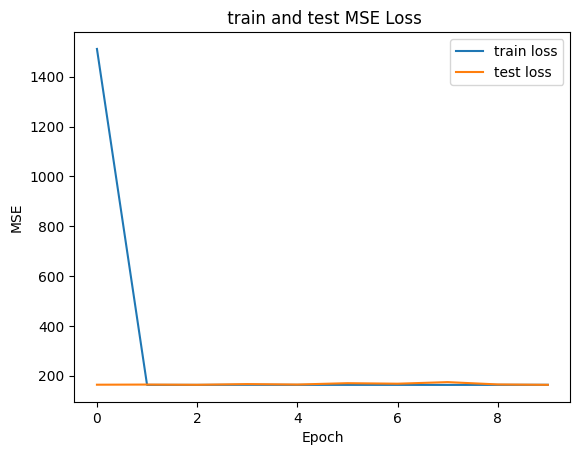

In [42]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
#plt.savefig('Less_chans-Loss.png')


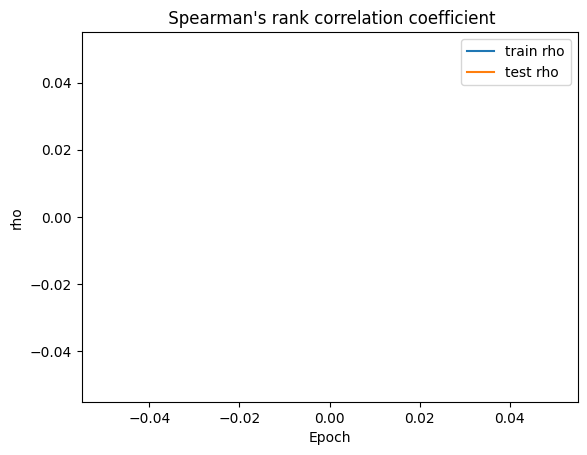

In [43]:
#Spearman's correlation coefficient
plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
#plt.savefig('Less_chanels-rho.png')

6. Kaggle submission

In [44]:
#Create the dataset
test_d = EnzymesDataset(test_df, False)

# create pytorch dataloaders

sub_dl = torch.utils.data.DataLoader(test_d, batch_size=batch_size, shuffle=True)
submission_df =  predict(model,sub_dl)


In [45]:
submission = pd.read_csv(path+ 'test.csv',index_col='seq_id')
submission['tm']=submission_df
submission = submission.drop(columns=['protein_sequence','pH','data_source'])
#test_sub.to_csv('3-LessChannels.csv', index=True)